# Problem 1

## 1.1 - CMD

In [227]:
import fsps
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [309]:
fname = 'M92_phot.txt'

vvega = []
vvega_err = []
vivega = []
vivega_err = []
with open(fname,'r') as f:
    for _ in xrange(1):
        line = f.readline()
        header = line.split()
        header = [val.strip(', \n') for val in header]
        print(header)
        print(np.where(header == 'Vvega'))
    for _ in xrange(2):
        next(f)
    for line in f:
        l = line.split()
        l = [float(val.strip(', \n')) for val in l]
        vvega.append(l[3])
        vvega_err.append(l[4])
        vivega.append(l[5]) #this is already v - i
        vivega_err.append(l[6]) #with correct errors

        
vvega = np.asarray(vvega)
vvega_err = np.asarray(vvega_err)
vivega = np.asarray(vivega)
vivega_err = np.asarray(vivega_err)



['id', 'x', 'y', 'Vvega', 'err', 'VIvega', 'err', 'Ivega', 'err', 'Vground', 'Iground', 'Nv', 'Ni', 'wV', 'wI', 'xsig', 'ysig', 'othv', 'othi', 'qfitV', 'qfitI', 'RA', 'Dec']
(array([], dtype=int64),)


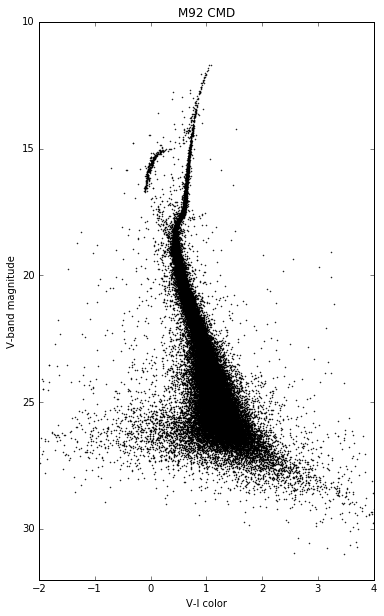

In [310]:
fig, ax = plt.subplots(figsize=(6, 10))

#Plot the data
ax.scatter(vivega,vvega,marker = '.',s=1,color='k')

#Make things pretty
ax.set_title('M92 CMD')
ax.set_xlabel('V-I color')
ax.set_ylabel('V-band magnitude')
ax.set_xlim([-2,4])
ax.set_ylim([32,10])
plt.show()

## 1.2 - Isochrone

In [230]:
filestemlist = ['m1.50','m1.75','m2.00','m2.50','m3.00']
isofilelist = ['MIST/MIST_v1.0_HST_ACSWF/MIST_v1.0_feh_'+val+'_afe_p0.0_vvcrit0.4_HST_ACSWF.iso.cmd' for val in filestemlist]

zarr = []
for isofile in isofilelist:
    arr = []
    iso = []
    with open(isofile,'r') as f:
        for line in f:
            l = line.split()
            if len(l) == 0:
                pass
            elif l[0].strip(', \n') == '#':
                if len(l) >= 8:
                    if l[3].strip(', \n') == 'EEPs' and l[4].strip(', \n') == 'cols':
                        arr.append(iso)
                        iso = []
                else:
                    pass
            else:
                l = line.split()
                l = [float(val.strip(', \n')) for val in l]
                iso.append(l)
        arr.append(iso)

    arr = arr[1:] #because we are appending a blank one at the beginning
    zarr.append(arr)

For each age (isochrone) each point corresponds to a star of different mass, all the way from 0.1 msun to 300 msun.  So far all of these are for the same metallicity, Fe/H = -2.0. Range of ages is 10$^5$ = 100,000 yr to 10$^{10.3}$ = 20 Gyr. Log_teff is column 3, log_g is column 4.

We need to adjust the absolute magnitudes of the isochrone to an apparent magnitude using the distance.  Wikipedia says the distance is 8.2 kpc.

In [231]:
def distance_modulus(d,M_abs):
    m = 5*np.log10(d) - 5 + M_abs #d in parsecs
    return m

Now let's extract the extinction table

In [232]:
extfile = 'MIST/HST_ACSWF/fehm200.HST_ACSWF'
ext = []
av = []
with open(extfile,'r') as f:
    for line in f:
        l = line.split()
        if len(l) == 0:
            pass
        elif l[0].strip(', \n') == '#':
            if len(l) >= 2:
                if l[1].strip(', \n') == 'Teff' and l[2].strip(', \n') == 'logg':
                    ext.append(av)
                    av = []
            else:
                pass
        else:
            l = line.split()
            l = [float(val.strip(', \n')) for val in l]
            av.append(l)
    ext.append(av)

ext = ext[1:] #because we are appending a blank one at the beginning

For each total reddening A_v, each point corresponds to a different Teff, logg pairing. F606W is column 10, F814 W is column 15. Need to find the correct Teff, logg for each star in the isochrone and apply the proper correction.

here I should correlate logg, Teff with the isochrones.  You'd think MIST would make this easier to do... going to ignore it for now

For now just use a simple extinction requirement

In [233]:
def extinction(mag,A):
    return mag - A

In [234]:
# keep only ages that make sense - greater than 9 Gyr
ages = []
for i in range(len(arr)):
    ages.append(zarr[0][i][0][1])
ages = np.asarray(ages)
agecut = np.where(ages >= np.log10(9e9))[0]
ages_used = ages[agecut]
print(ages_used)

[ 10.    10.05  10.1   10.15  10.2   10.25  10.3 ]


Now let's plot a whole bunch of isochrones together:

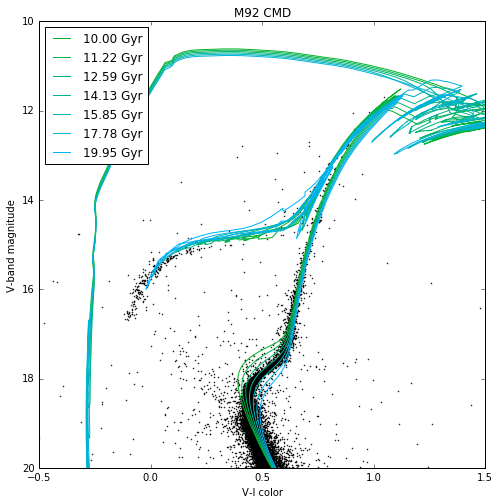

In [235]:
A_v = 0.0
A_i = 0.04
d = 8200 #pc

arr = zarr[2] #Only metallicity Fe/H = -2.00 for now

fig, ax = plt.subplots(figsize=(8, 8))

#Plot the data
ax.scatter(vivega,vvega,marker = '.',s=1,color='k')

#Plot the isochrones
for i in range(len(agecut)):
    iso = arr[agecut[i]] 
    
    F606W = [val[12] for val in iso]
    F814W = [val[17] for val in iso]
    F606W = np.asarray(F606W)
    F814W = np.asarray(F814W)
    
    F606W = distance_modulus(d,F606W)
    F814W = distance_modulus(d,F814W)
    
    F606W = extinction(F606W,A_v)
    F814W = extinction(F814W,A_i)
    
    legendstr = '{:.2f} Gyr'.format(10**ages_used[i]/1e9)
    
    ax.plot(F606W - F814W,F606W,lw=1,color = (0,0.7,float(i+1)/float(len(agecut))), label = legendstr)
    
#Make things pretty
ax.set_title('M92 CMD')
ax.set_xlabel('V-I color')
ax.set_ylabel('V-band magnitude')
ax.set_xlim([-0.5,1.5])
ax.set_ylim([20,10])
ax.legend(loc='upper left')
plt.show()

Let's do it with metallicities instead of ages, assuming an age of 12.6 Gyr for all of them.

In [272]:
z_used = [-1.5,-1.75,-2.0,-2.5,-3.0]
legendstrs = ['[Fe/H] = '+str(val) for val in z_used]

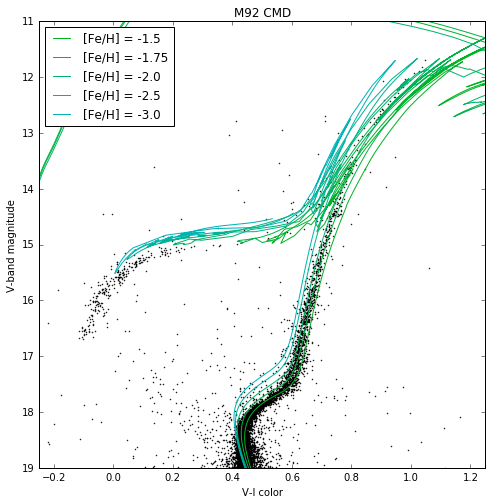

In [274]:
A_v = 0.0
A_i = 0.03
d = 8200 #pc

fig, ax = plt.subplots(figsize=(8, 8))

#Plot the data
ax.scatter(vivega,vvega,marker = '.',s=1,color='k')

#Plot the isochrones
for i in range(len(zarr)):
    iso = zarr[i][agecut[2]] #all metallicities from -1.5 to -3

    F606W = [val[12] for val in iso]
    F814W = [val[17] for val in iso]
    F606W = np.asarray(F606W)
    F814W = np.asarray(F814W)
    
    F606W = distance_modulus(d,F606W)
    F814W = distance_modulus(d,F814W)
    
    F606W = extinction(F606W,A_v)
    F814W = extinction(F814W,A_i)
    
    legendstr = legendstrs[i]
    
    ax.plot(F606W - F814W,F606W,lw=1,color = (0,0.7,float(i+1)/float(len(agecut))), label = legendstr)
    
#Make things pretty
ax.set_title('M92 CMD')
ax.set_xlabel('V-I color')
ax.set_ylabel('V-band magnitude')
ax.set_xlim([-0.25,1.25])
ax.set_ylim([19,11])
ax.legend(loc='upper left')
plt.show()

Cool, so that's working.  Now let's MCMC.

What we really need here is an interpolation of magnitudes on a grid of distance, age, metallicity. Is it possible to just linearly interpolate each walker's guess between our known points?  Let's try it.

In [238]:
import emcee

In [270]:
#theta = [distance, log_age, log_fe/h]

zcut = np.asarray(range(5))
agecut = np.asarray(agecut)

def find_nearest_indices(array,value):
    array = np.abs(array)
    value = np.abs(value)
    idx = np.searchsorted(array, value, side="left")
    if idx > 0:
        return idx-1, idx
    else:
        return -np.inf

def make_mags(theta):
    '''The idea is to find the nearest models to the theta values the walker
    finds, then take the weighted average of the magnitudes at those points
    where the weights are determined by how close to each nearby model the walker is.
    ages_used and z_used are the age and metallicity values that are on our grid, 
    whereas agecut and zcut are the indices of those.'''
    
    #figure out what points on our grid the walker is nearest to
    z_i,z_j = find_nearest_indices(z_used,theta[2])
    age_i,age_j = find_nearest_indices(ages_used,theta[1])
    
    #Out of those points, how close is the walker to each? wt_i has value from 0 to 1
    dist_zi = (theta[2] - z_used[z_i])/(z_used[z_j] - z_used[z_i])
    dist_zj = (theta[2] - z_used[z_j])/(z_used[z_j] - z_used[z_i])
    dist_agei = (theta[1] - ages_used[age_i])/(ages_used[age_j] - ages_used[age_i])
    dist_agej = (theta[1] - ages_used[age_j])/(ages_used[age_j] - ages_used[age_i])
    
    #Now combine those weights to centroid the point the walker found
    dist00 = np.sqrt(dist_zi**2 + dist_agei**2)
    dist01 = np.sqrt(dist_zi**2 + dist_agej**2)
    dist10 = np.sqrt(dist_zj**2 + dist_agei**2)
    dist11 = np.sqrt(dist_zj**2 + dist_agej**2)
    
    #do 1/dist = weight, normalize the weights
    ds = [dist00,dist01,dist10,dist11]
    wts = []
    for dist in ds:
        wts.append(1/dist)
    
    norm_constant = np.sum(wts)
    wts = np.asarray(wts)
    wts = wts/norm_constant    
    
    #Extract the four isochrone magnitudes and apply weights
    iso00 = zarr[z_i][agecut[age_i]]
    iso01 = zarr[z_i][agecut[age_j]]
    iso10 = zarr[z_j][agecut[age_i]]
    iso11 = zarr[z_j][agecut[age_j]]
    isos = [iso00,iso01,iso10,iso11]
    
    F606 = []
    F814 = []
    for k in range(len(isos)):
        
        f606w = wts[k]*np.asarray([val[12] for val in isos[k]])
        f814w = wts[k]*np.asarray([val[17] for val in isos[k]])
        
        F606.append(f606w)
        F814.append(f814w)

    #Average them
    F606W = np.add(F606)/4
    F814W = np.add(F814)/4
    
    '''This is the relatively easy part, since distance can be any value.
    It will just scale the magnitudes we found'''
    F606W = distance_modulus(theta[0],F606W)
    F814W = distance_modulus(theta[0],F814W)
    return F606W,F814W



theta = np.asarray([8200,10.049,-2.01])
F606W, F814W = make_mags(theta)

print(z_used[2],ages_used[1])
'''
iso = zarr[2][agecut[1]] #all metallicities from -1.5 to -3
F606W = np.asarray([val[12] for val in iso])
F814W = np.asarray([val[17] for val in iso])

F606W = distance_modulus(theta[0],F606W)
F814W = distance_modulus(theta[0],F814W)
'''

ValueError: operands could not be broadcast together with shapes (1463,) (460,) 

In [ ]:
from scipy.interpolate import griddata

def interpolator(zarr,f606w,f814w):
    points = [z_used,ages_used]
    values = zarr[zcut][agecut]
    grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
    grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
    grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')
    


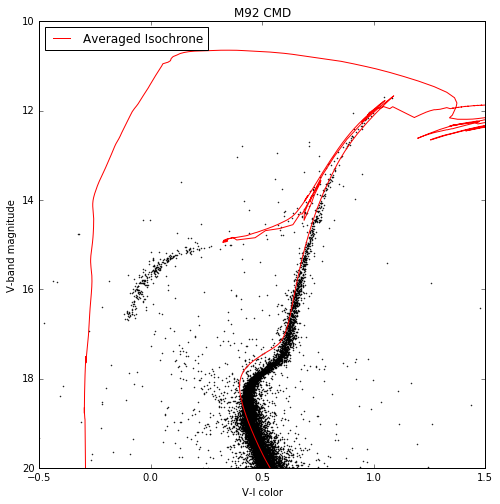

In [268]:
fig, ax = plt.subplots(figsize=(8, 8))

#Plot the data
ax.scatter(vivega,vvega,marker = '.',s=1,color='k')

#Plot the isochrone
F606W = extinction(F606W,A_v)
F814W = extinction(F814W,A_i)
ax.plot(F606W - F814W,F606W,lw=1,color = 'red', label = 'Averaged Isochrone')
    
#Make things pretty
ax.set_title('M92 CMD')
ax.set_xlabel('V-I color')
ax.set_ylabel('V-band magnitude')
ax.set_xlim([-0.5,1.5])
ax.set_ylim([20,10])
ax.legend(loc='upper left')
plt.show()

Justification of priors:

Distance - Wikipedia says the answer, but it's pretty clear that neither metallicity or age is going to give you huge up-and-down shifts on the plot (i.e. huge changes to magnitude but not color) so let's say that worse than a factor of ~2 off in distance is impossible.  Can probably make it more stringent later

Age - It's a globular cluster, so based on what we saw in class it isn't younger than 9 Gyr. It can't be older than the Universe, so let's put the upper bound at 13.7 Gyr

Metallicity - 

In [241]:
def lnlike(theta,stars):
    
    F606W,F814W = make_mags(theta)
    
    
    lnlk = np.sum()
    return lnlk

def lnprior(theta,stars):
    '''Flat prior for now.'''
    if 5000 < theta[0] < 15000 and np.log10(9e9) < theta[1] < np.log10(13.7e9) and -3.0 < theta[2] < -1.5:
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta,stars):
    if np.isfinite(lnprior(theta,stars)):
        return lnprior(theta,stars) + lnlike(theta,stars)
    else:
        return -np.inf

thetaguess = np.asarray([8200,np.log10(11e9),-2.0])
def p0gen(thetaguess):
    '''Takes in a guess at params, makes tiny ball of walkers around it
    ensuring distance between walkers in each dimension is proportional
    to the characteristic size scale'''
    return np.add(np.multiply(1e-2*np.random.randn(len(thetaguess)),thetaguess),thetaguess)

ndim, nwalkers = 3, 100

#randomize initial position of walkers
p0 = [p0gen(thetaguess) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[stars])
sampler.run_mcmc(p0, 1000)

fig = corner.corner(sampler.flatchain, labels=['$D$', r'$\log $ Age (Gyr)',r'$\log$ [Fe/H]'])
plt.show()

NameError: name 'stars' is not defined

## 1.2 (again)

Do a better job now. Take extinction from NED = 0.06 mag, download custom tables from the MIST website with the correct spacing of 0.05 dex in metallicity and age given that extinction.  Also use the Python routine that MIST provides for reading the isochrones.

Magnitude range 9.8 < log(age) < 10.25 in 0.05 dex steps. Metallicity range -2.5 < [Fe/H] < -1.5 in 0.05 dex steps.

In [387]:
import read_mist_models
import os
import corner

In [595]:
dirname = './MIST_custom'

fehs = []
cmds = {}
for file in os.listdir(dirname):
    if file.endswith(".cmd"):
        isocmd = read_mist_models.ISOCMD(dirname+'/'+file)
        feh = isocmd.abun['[Fe/H]']
        fehs.append(feh)
        cmds[feh] = isocmd
        print 'ages: ', [round(x,2) for x in isocmd.ages]
        '''
        print 'version: ', isocmd.version
        print 'photometric system: ', isocmd.photo_sys
        print 'abundances: ', isocmd.abun
        print 'rotation: ', isocmd.rot
        print 'ages: ', [round(x,2) for x in isocmd.ages]
        print 'number of ages: ', isocmd.num_ages
        print 'available columns: ', isocmd.hdr_list
        print 'Av extinction: ', isocmd.Av_extinction
        '''
        # Following the FSPS notation, PMS:-1 ; MS:0 ; SGB+RGB:2 ; CHeB:3 ; EAGB:4 ; TPAGB:5 ; post-AGB:6 ; WR:9

Reading in: ./MIST_custom/MIST_iso_1475800521.iso.cmd
ages:  [9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25]
Reading in: ./MIST_custom/MIST_iso_1475800541.iso.cmd
ages:  [9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25]
Reading in: ./MIST_custom/MIST_iso_1475800561.iso.cmd
ages:  [9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25]
Reading in: ./MIST_custom/MIST_iso_1475800579.iso.cmd
ages:  [9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25]
Reading in: ./MIST_custom/MIST_iso_1475800593.iso.cmd
ages:  [9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25]
Reading in: ./MIST_custom/MIST_iso_1475800604.iso.cmd
ages:  [9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25]
Reading in: ./MIST_custom/MIST_iso_1475800628.iso.cmd
ages:  [9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25]
Reading in: ./MIST_custom/MIST_iso_1475800677.iso.cmd
ages:  [9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25]
Reading in: ./MIST_custom/MIST_iso_1475800691.iso.cmd
ag

[Fe/H]:  -1.9
available columns:  ['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'log_Teff', 'log_g', 'log_L', 'Z_surf', 'ACS_WFC_F435W', 'ACS_WFC_F475W', 'ACS_WFC_F502N', 'ACS_WFC_F550M', 'ACS_WFC_F555W', 'ACS_WFC_F606W', 'ACS_WFC_F625W', 'ACS_WFC_F658N', 'ACS_WFC_F660N', 'ACS_WFC_F775W', 'ACS_WFC_F814W', 'ACS_WFC_F850LP', 'ACS_WFC_F892N', 'phase']


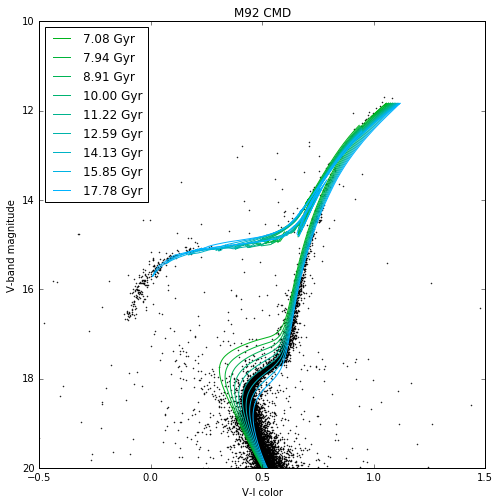

In [594]:
d = 8600
isocmd = cmds[-1.9]
print '[Fe/H]: ', isocmd.abun['[Fe/H]']
print 'available columns: ', isocmd.hdr_list
ages = [round(x,2) for x in isocmd.ages] #this is the same for all datasets so we can just use it

fig, ax = plt.subplots(figsize=(8, 8))

#Plot the data
ax.scatter(vivega,vvega,marker = '.',s=1,color='k')

for i in range(len(ages)):
    age = ages[i]
    age_ind = isocmd.age_index(age) #returns the index for the desired age

    V = isocmd.isocmds[age_ind]['ACS_WFC_F606W']
    I = isocmd.isocmds[age_ind]['ACS_WFC_F814W']

    phase = isocmd.isocmds[age_ind]['phase']
    V = V[np.logical_and(0 <= phase,phase < 5)]
    I = I[np.logical_and(0 <= phase,phase < 5)]    
    V = distance_modulus(d,V)
    I = distance_modulus(d,I)    
    VI = V - I
    legendstr = '{:.2f} Gyr'.format(10**age/1e9)
    ax.plot(VI,V, lw=1,color = (0,0.7,float(i+1)/float(len(ages))), label = legendstr)
    
#Make things pretty
ax.set_title('M92 CMD')
ax.set_xlabel('V-I color')
ax.set_ylabel('V-band magnitude')
ax.set_xlim([-0.5,1.5])
ax.set_ylim([20,10])
ax.legend(loc='upper left')
plt.show()   
    


Wow, this is much easier to work with.  My by-eye best fit parameters are d = 8600, age = 13 Gyr, [Fe/H] = -1.9. Now let's set up MCMC again. This time instead of interpolating to a model just pick a model.

In [545]:
#limiting the data to be only in the region of interest, right around the MSTO.  Let's call it 10 > V > 19
V_data = vvega[vvega > 11]
VI_data = vivega[vvega > 11] #already V-I
V_err = vvega_err[vvega > 11]
VI_err = vivega_err[vvega > 11]

V_data = V_data[V_data < 18]
VI_data = VI_data[V_data < 18]
V_err = V_err[V_data < 18]
VI_err = VI_err[V_data < 18]

stars = [VI_data,V_data,VI_err,V_err]

/Users/emolter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 142970 but corresponding boolean dimension is 2705
/Users/emolter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 142970 but corresponding boolean dimension is 2705
/Users/emolter/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 142970 but corresponding boolean dimension is 2705


In [546]:
def closest_node(node, nodes):
    '''Takes in a point an an array, finds the minimum distance between the point and one of the array points'''
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.min(dist_2),np.argmin(dist_2)

x = np.asarray([[1,2,3,4,5,6,7,8,9,10],[1,3,5,7,3,4,5,6,6,6]]).T
y = np.asarray([[2,3,4,5,5,3,4,12],[3,3,2,4,5,3,2,3]]).T

print(closest_node(y[1],x),closest_node(y[-1],x))

def arr_dist(arr1,arr2):
    '''Using closest_node to generate a sum of the distances between the closest points.
    arr1 should be the shorter array'''
    s = 0.0
    for node in arr1:
        s += closest_node(node,arr2)[0]
    return s

def arr_dist_gaussian(arr1,arr2,arr2_err):
    '''Using closest_node to generate a sum of the distances between the closest points.
    arr1 should be the shorter array'''
    s = 0.0
    for node in arr1:
        d2,i = closest_node(node,arr2) #d2 is the distance squared, i is the index of the node
        err2 = arr2_err[i][0]**2 + arr2_err[i][1]**2
        #print(i,d2/err2)
        s += -0.5*(d2/err2 + np.log(2.*np.pi*err2))
    return s

def arr_dist_gaussian_2(arr1,arr2,arr1_err):
    '''Using closest_node to generate a sum of the distances between the closest points.
    arr1 should be the shorter array'''
    s = 0.0
    for i in range(len(arr2)):
        node = arr2[i]
        d2,j = closest_node(node,arr1) #d2 is the distance squared, i is the index of the node
        err2 = arr1_err[i][0]**2 + arr1_err[i][1]**2
        #print(j,d2/err2)
        s += -0.5*(d2/err2 + np.log(2.*np.pi*err2))
    return s

((1, 1), (13, 9))


In [547]:
arr1 = np.asarray([[1,1],[2,2],[3,3],[4,4],[5,5]])
arr2 = np.asarray([[1.1,0.9],[1.6,2.4],[5.1,5.1],[1.001,1.00],[12,7]])
arr2_err = np.asarray([[0.3,0.3],[0.3,0.3],[0.3,0.3],[0.3,0.3],[0.3,0.3]])
print(arr_dist_gaussian(arr1,arr2,arr2_err))
print(arr_dist_gaussian_2(arr1,arr2,arr2_err))

-14.4188104847
-148.529921596


In [548]:
#theta = [distance, log_age, log_fe/h]
#stars = [VI_data, V_data, VI_err, V_err]

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

def lnlike(theta,stars):
    #Find the model that corresponds to the theta the walker has chosen
    feh = find_nearest(fehs,theta[2]) #fehs is a list of all the metallicities I have - just find nearest model
    age = find_nearest(ages,theta[1]) #similarly
    
    isocmd = cmds[feh]
    age_ind = isocmd.age_index(age) #returns the index for the desired age

    V = isocmd.isocmds[age_ind]['ACS_WFC_F606W']
    I = isocmd.isocmds[age_ind]['ACS_WFC_F814W']
    phase = isocmd.isocmds[age_ind]['phase']
    V = V[np.logical_and(0 < phase, phase < 5)] #remove the track going toward white dwarf b/c almost no stars on it
    I = I[np.logical_and(0 < phase, phase < 5)]
    
    #Do the distance modulus
    V = distance_modulus(theta[0],V)
    I = distance_modulus(theta[0],I)
    VI = V - I
    
    model = np.asarray([VI,V]).T
    
    #Now bring in the data
    V_data = stars[1]
    VI_data = stars[0]
    V_err = stars[3]
    VI_err = stars[2]
    
    data = np.asarray([VI_data,V_data]).T
    err = np.asarray([VI_err,V_err]).T

    #figure out how many sigma away from model the data is, sum those
    #lk = arr_dist_gaussian(model,data,err)
    lk = arr_dist_gaussian_2(data,model,err) 
    return lk

def lnprior(theta,stars):
    '''Flat prior for now.'''
    if 5000 < theta[0] < 15000 and np.min(ages) <= theta[1] <= np.max(ages) and np.min(fehs) <= theta[2] <= np.max(fehs):
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta,stars):
    if np.isfinite(lnprior(theta,stars)):
        return lnprior(theta,stars) + lnlike(theta,stars)
    else:
        return -np.inf

In [549]:
theta = np.asarray([8200,9.85,-1.5])
print(lnprob(theta,stars))

-1112.85045025


In [552]:
theta = np.asarray([10200,10.0,-2.0])
print(lnprob(theta,stars))

theta = np.asarray([9200,10.0,-2.0])
print(lnprob(theta,stars))

theta = np.asarray([8200,10.0,-2.0])
print(lnprob(theta,stars))

theta = np.asarray([7200,10.0,-2.0])
print(lnprob(theta,stars))

theta = np.asarray([6200,10.0,-2.0])
print(lnprob(theta,stars))

theta = np.asarray([5200,10.0,-2.0])
print(lnprob(theta,stars))

-1118.20113316
-1147.14166756
-1653.49249059
-2112.72007915
-3929.63528459
-11645.1111046


In [553]:
theta = np.asarray([8200,9.90,-2.0])
print(lnprob(theta,stars))

theta = np.asarray([8200,10.0,-2.0])
print(lnprob(theta,stars))

theta = np.asarray([8200,10.1,-2.0])
print(lnprob(theta,stars))

-1031.34531986
-1653.49249059
-4247.6845663


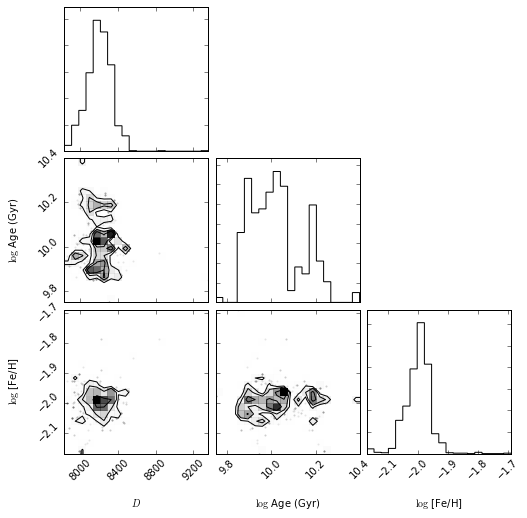

In [554]:
thetaguess = np.asarray([8200,np.log10(11e9),-2.0])
def p0gen(thetaguess):
    '''Takes in a guess at params, makes tiny ball of walkers around it
    ensuring distance between walkers in each dimension is proportional
    to the characteristic size scale'''
    return np.add(np.multiply(1e-2*np.random.randn(len(thetaguess)),thetaguess),thetaguess)

ndim, nwalkers = 3, 100

#randomize initial position of walkers
p0 = [p0gen(thetaguess) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[stars])
sampler.run_mcmc(p0, 10)

fig = corner.corner(sampler.flatchain, labels=['$D$', r'$\log $ Age (Gyr)',r'$\log$ [Fe/H]'])
plt.show()

Amazingly, this actually seems to work!  What happens if we screw around with our guess?

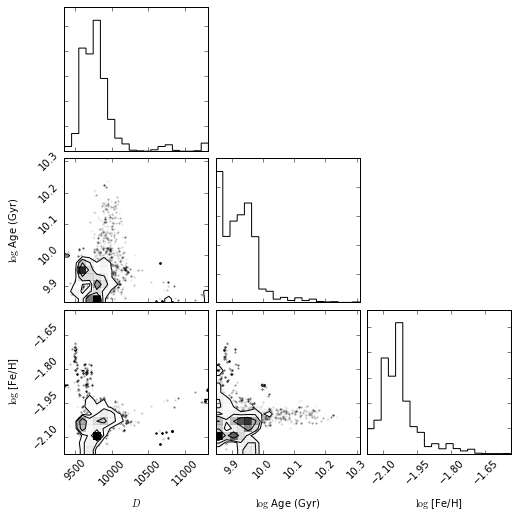

In [555]:
thetaguess = np.asarray([10000,np.log10(11e9),-2.0])
def p0gen(thetaguess):
    '''Takes in a guess at params, makes tiny ball of walkers around it
    ensuring distance between walkers in each dimension is proportional
    to the characteristic size scale'''
    return np.add(np.multiply(1e-2*np.random.randn(len(thetaguess)),thetaguess),thetaguess)

ndim, nwalkers = 3, 100

#randomize initial position of walkers
p0 = [p0gen(thetaguess) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[stars])
sampler.run_mcmc(p0, 100)

fig = corner.corner(sampler.flatchain, labels=['$D$', r'$\log $ Age (Gyr)',r'$\log$ [Fe/H]'])
plt.show()

It's now finding the minimum allowed value of the age... that's not good

Need to move on now.  May come back later.

## 1.3 - Parsec Models

In [905]:
# make a reader
dirname = './PARSEC'
fnames = os.listdir(dirname)
fnames = [dirname+'/'+val for val in fnames]

ages = np.arange(9.85,10.15,0.05)
print(ages)


isos = []
metals = []
for fname in fnames:
    iso_z = []
    iso = np.genfromtxt(fname,comments='#')
    metals.append(iso[0,0])
    for age in ages:
        iso_age = iso[np.where(iso[:,1] == age)]
        iso_z.append(iso_age)
        print(len(iso_age))
    isos.append(iso_z)

isos = np.asarray(isos)
print(np.shape(isos))

[  9.85   9.9    9.95  10.    10.05  10.1   10.15]
192
189
0
0
0
0
0
197
195
0
0
0
0
0
205
204
0
0
0
0
0
193
190
0
0
0
0
0
201
197
0
0
0
0
0
195
206
0
0
0
0
0
193
189
0
0
0
0
0
195
205
0
0
0
0
0
191
186
0
0
0
0
0
194
206
0
0
0
0
0
(10, 7)


In [685]:
print(isos['0.0008']['10.0'])

[]


# Problem 2

## 2.1

In [779]:
# Assume d = 8.2 kpc, age = 12.5 Gyr, log[Fe/H] = -2.1
#using MILES spectral library and MIST evolution models

age = 12.5 #Gyr
feh = -2.1
zmet = 2 # this is a metallicity of 1% solar in the MIST models
cluster_mass = 2.0e5 #msun

sp = fsps.StellarPopulation(compute_vega_mags=False, sfh=0, tage = age, zmet = zmet)

In [780]:
mags = sp.get_mags(tage = age, bands=['WFC_ACS_F606W', 'WFC_ACS_F814W'])
model_mass = sp.stellar_mass

In [787]:
v = mags.T[0]
i = mags.T[1]
vi = v - i
print(v,i,vi)
print('Model mass = '+str(mass)+' Msun') #normalized to be 1 solar mass at zero age

(6.0868301566630123, 5.7614574078025953, 0.325372748860417)
Model mass = 0.576208663973 Msun


In [788]:
mass_ratio = cluster_mass/model_mass
print('Mass ratio = '+str(mass_ratio))

Mass ratio = 347096.481717


In [789]:
#Need to make this the same mass as the cluster we actually observe. Multiply luminosities by the mass ratio
# I figure twice as many stars will just be twice as luminous.

def mag_lum(mag):
    '''Msun = 4.85'''
    return 10**(-0.4*(mag-4.85))

def lum_mag(lum):
    return 4.85 - 2.5*np.log10(lum)

v_cluster = lum_mag(mass_ratio*mag_lum(v))
i_cluster = lum_mag(mass_ratio*mag_lum(i))

In [791]:
print(v_cluster,i_cluster)

(-7.7642953721954964, -8.0896681210559134)


In [793]:
d = 8200
v_app = distance_modulus(d,v_cluster)
i_app = distance_modulus(d,i_cluster)
print(v_app,i_app)

(6.8047738897230889, 6.4794011408626719)


## 2.2

In [796]:
# Assume the cluster mass is perfectly known
sigma = 0.1 #mag


v_with_err = np.random.normal(v_app,sigma,1)
i_with_err = np.random.normal(i_app,sigma,1)

stars = [v_with_err,i_with_err,sigma]

[-0.08283442]


Justification of priors: we know this has to be an old cluster so we constrain to be older than 9 Gyr. We also know it's metal poor so let's force it to be less than 10% of the Sun, which is zmet = 6. Need to keep zmet at or above 1, so force 6.5 > theta[2] > 0.5.

In [826]:
#theta = [distance (pc), age (Gyr), zmet]
#stars = [v,i,sigma]

def lnlike(theta,stars):
    #initialize variables
    dist = theta[0]
    age = theta[1]
    zmet = int(np.around(theta[2]))
    
    v_data = stars[0]
    i_data = stars[1]
    sigma = stars[2]
    
    #adjust stellar model
    sp.params['zmet'] = zmet
    mags = sp.get_mags(tage = age, bands=['WFC_ACS_F606W', 'WFC_ACS_F814W'])
    model_mass = sp.stellar_mass
    v = mags.T[0]
    i = mags.T[1]
    
    #put the model at the correct mass and distance
    mass_ratio = cluster_mass/model_mass
    v_cluster = lum_mag(mass_ratio*mag_lum(v))
    i_cluster = lum_mag(mass_ratio*mag_lum(i))
    v_app = distance_modulus(dist,v_cluster)
    i_app = distance_modulus(dist,i_cluster)
    
    #compute difference between v and i, put into Gaussian
    lnlk = -0.5 * np.sum(((v_app - v_data)**2 + (i_app - i_data)**2)/(2. * sigma**2))
    return lnlk

In [827]:
print(lnlike([8200,10.0,3],stars))

-4.25742360741


In [828]:
def lnprior(theta,stars):
    '''Flat prior for now.'''
    if 5000 < theta[0] < 15000 and 9.0 <= theta[1] <= 13.7 and 0.5 < theta[2] < 6.5:
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta,stars):
    if np.isfinite(lnprior(theta,stars)):
        return lnprior(theta,stars) + lnlike(theta,stars)
    else:
        return -np.inf

    

In [850]:
ndim, nwalkers = 3, 100  
thetaguess = np.asarray([8200,11.0,5])
def p0gen(thetaguess):
    '''Takes in a guess at params, makes tiny ball of walkers around it
    ensuring distance between walkers in each dimension is proportional
    to the characteristic size scale'''
    return np.add(np.multiply(1e-1*np.random.randn(len(thetaguess)),thetaguess),thetaguess)

#randomize initial position of walkers
p0 = [p0gen(thetaguess) for i in range(nwalkers)]

sampler_1 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[stars])
sampler_1.run_mcmc(p0, 1000)

(array([[  8.85295971e+03,   1.11342502e+01,   3.23562794e+00],
        [  7.98980572e+03,   1.19784623e+01,   9.67647895e-01],
        [  7.76089473e+03,   1.24414807e+01,   6.02457230e+00],
        [  7.18451813e+03,   1.28691309e+01,   8.45858790e-01],
        [  8.00034470e+03,   1.16677771e+01,   2.79712278e+00],
        [  7.96074106e+03,   1.36459630e+01,   4.03406221e+00],
        [  8.91749994e+03,   9.09060967e+00,   5.66385001e+00],
        [  8.76202694e+03,   1.08298415e+01,   1.29007247e+00],
        [  7.74105957e+03,   1.16368197e+01,   3.68423774e+00],
        [  8.28928403e+03,   1.30334010e+01,   3.68926344e+00],
        [  7.05443343e+03,   1.19074254e+01,   1.08198087e+00],
        [  9.10697090e+03,   1.10367865e+01,   6.26406059e+00],
        [  1.03032635e+04,   9.24274732e+00,   2.75926807e+00],
        [  8.32341280e+03,   1.13710068e+01,   1.69218150e+00],
        [  7.71492714e+03,   1.15833180e+01,   2.87391794e+00],
        [  8.57009016e+03,   1.17709041e

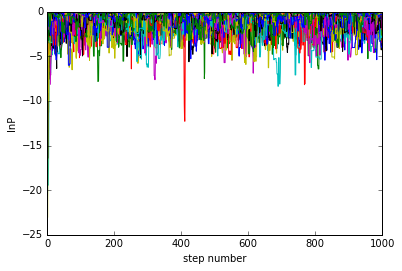

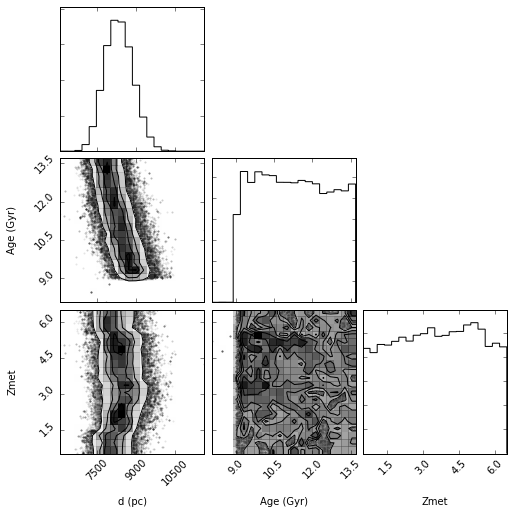

In [851]:
[plt.plot(sampler_1.lnprobability[i,:]) for i in range(100)]
plt.xlabel('step number')
plt.ylabel('lnP')
plt.show()

fig = corner.corner(sampler_1.flatchain[4000:], labels=['d (pc)','Age (Gyr)','Zmet'])
plt.show()

Wow, we don't get very much information.  There's a slight preference for the extremely low metallicities that I'd be most inclined to believe; however, there's a preference for low ages that I don't believe. The distance seems not to want to stray too far either. What if we perturb the distance guess?

In [852]:
ndim, nwalkers = 3, 100  
thetaguess = np.asarray([10200,11.0,5])
def p0gen(thetaguess):
    '''Takes in a guess at params, makes tiny ball of walkers around it
    ensuring distance between walkers in each dimension is proportional
    to the characteristic size scale'''
    return np.add(np.multiply(1e-1*np.random.randn(len(thetaguess)),thetaguess),thetaguess)

#randomize initial position of walkers
p0 = [p0gen(thetaguess) for i in range(nwalkers)]

sampler_2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[stars])
sampler_2.run_mcmc(p0, 1000)

(array([[  7.86171010e+03,   1.00361580e+01,   3.65302349e+00],
        [  8.81630582e+03,   1.19902659e+01,   5.05005285e+00],
        [  8.60476895e+03,   1.17921068e+01,   2.44720979e+00],
        [  7.15785747e+03,   1.30696755e+01,   6.33554480e-01],
        [  8.79629604e+03,   1.04109920e+01,   3.42380617e+00],
        [  7.80468754e+03,   1.28302989e+01,   2.88329931e+00],
        [  8.57003582e+03,   1.03273543e+01,   3.42686850e+00],
        [  7.47097685e+03,   1.26427865e+01,   5.96396166e+00],
        [  8.50362618e+03,   1.02376491e+01,   2.40027021e+00],
        [  8.26435299e+03,   1.24226554e+01,   1.03754791e+00],
        [  9.25501706e+03,   9.25908148e+00,   2.89893118e+00],
        [  8.04783647e+03,   1.01948174e+01,   8.44282165e-01],
        [  8.73345136e+03,   1.00350890e+01,   4.78638903e+00],
        [  8.19085151e+03,   1.18061007e+01,   2.29810643e+00],
        [  8.67682605e+03,   1.09176301e+01,   4.29653288e+00],
        [  8.47522613e+03,   1.04959590e

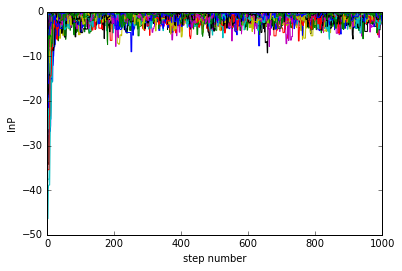

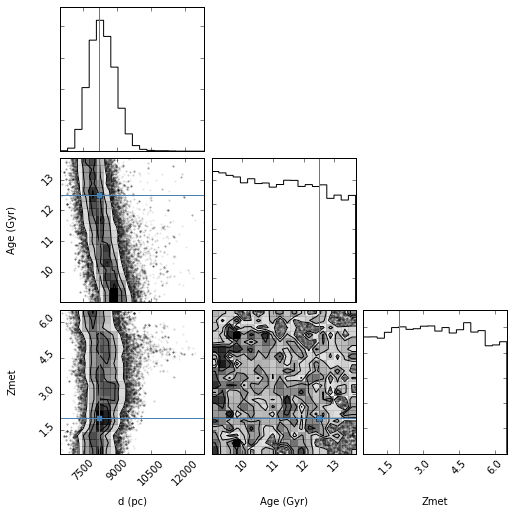

In [853]:
[plt.plot(sampler_2.lnprobability[i,:]) for i in range(100)]
plt.xlabel('step number')
plt.ylabel('lnP')
plt.show()

fig = corner.corner(sampler_2.flatchain[4000:], labels=['d (pc)','Age (Gyr)','Zmet'],truths=[8200,12.5,2])
plt.show()

In [ ]:
flatchn = sampler_2.flatchain[4000:]
print(np.shape(flatchn))

So it at least finds the 'correct' distance.

## 2.3

In [856]:
# Assume the cluster mass is perfectly known
sigma = 0.01 #mag


v_with_err = np.random.normal(v_app,sigma,1)
i_with_err = np.random.normal(i_app,sigma,1)

stars = [v_with_err,i_with_err,sigma]

In [857]:
ndim, nwalkers = 3, 100  
thetaguess = np.asarray([8200,11.0,2])

#randomize initial position of walkers
p0 = [p0gen(thetaguess) for i in range(nwalkers)]

sampler_3 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[stars])
sampler_3.run_mcmc(p0, 1000)

(array([[  8.37537816e+03,   1.17818331e+01,   2.12137123e+00],
        [  8.22233327e+03,   1.08925790e+01,   1.21680059e+00],
        [  8.10156281e+03,   1.31546816e+01,   1.52377611e+00],
        [  7.97518129e+03,   1.29101804e+01,   3.96091774e+00],
        [  8.34352685e+03,   1.15642369e+01,   2.04006416e+00],
        [  9.01949389e+03,   9.35595112e+00,   3.74782888e+00],
        [  8.78385988e+03,   9.54031392e+00,   1.77240868e+00],
        [  8.40747555e+03,   1.07994318e+01,   1.88981733e+00],
        [  8.47932821e+03,   1.06637985e+01,   1.75578210e+00],
        [  8.44276487e+03,   1.07713444e+01,   2.41656190e+00],
        [  8.23785448e+03,   1.23332878e+01,   2.26589719e+00],
        [  8.70935786e+03,   9.85550687e+00,   2.03980233e+00],
        [  8.93342287e+03,   1.00430472e+01,   3.02802485e+00],
        [  8.33063408e+03,   1.18959228e+01,   2.07267834e+00],
        [  8.19417769e+03,   1.24738527e+01,   1.87330177e+00],
        [  8.93879347e+03,   9.75841925e

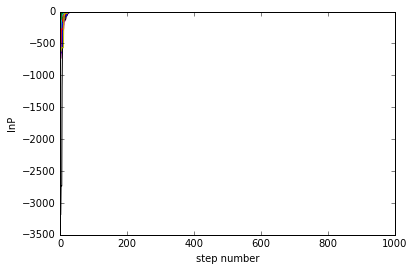

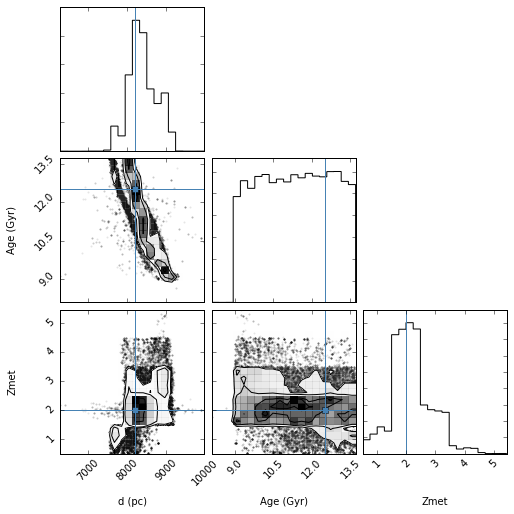

In [858]:
[plt.plot(sampler_3.lnprobability[i,:]) for i in range(100)]
plt.xlabel('step number')
plt.ylabel('lnP')
plt.show()

fig = corner.corner(sampler_3.flatchain[4000:], labels=['d (pc)','Age (Gyr)','Zmet'],truths=[8200,12.5,2])
plt.show()

This has clearly improved things - much more strongly constrains the metallicity, and the age at least finds the "correct" maximum value despite remaining quite poorly constrained.

## 2.4

In [859]:
# Assume d = 8.2 kpc, age = 12.5 Gyr, log[Fe/H] = -2.1
#using MILES spectral library and MIST evolution models

d = 8200
age = 12.5 #Gyr
feh = -2.1
zmet = 2 # this is a metallicity of 1% solar in the MIST models
cluster_mass = 2.0e5 #msun # Assume the cluster mass is perfectly known
sigma = 0.1 #mag

sp = fsps.StellarPopulation(compute_vega_mags=False, sfh=0, tage = age, zmet = zmet)

In [860]:
mags = sp.get_mags(tage = age, bands=['u','b','WFC_ACS_F606W', 'WFC_ACS_F814W'])
u,b,v,i = mags.T[0],mags.T[1],mags.T[2],mags.T[3]
model_mass = sp.stellar_mass
mass_ratio = cluster_mass/model_mass

In [861]:
u_cluster = lum_mag(mass_ratio*mag_lum(u))
b_cluster = lum_mag(mass_ratio*mag_lum(b))
v_cluster = lum_mag(mass_ratio*mag_lum(v))
i_cluster = lum_mag(mass_ratio*mag_lum(i))

u_app = distance_modulus(d,u_cluster)
b_app = distance_modulus(d,b_cluster)
v_app = distance_modulus(d,v_cluster)
i_app = distance_modulus(d,i_cluster)

In [862]:
u_with_err = np.random.normal(u_app,sigma,1)
b_with_err = np.random.normal(b_app,sigma,1)
v_with_err = np.random.normal(v_app,sigma,1)
i_with_err = np.random.normal(i_app,sigma,1)

stars = [u_with_err,b_with_err,v_with_err,i_with_err,sigma]

In [863]:
#theta = [distance (pc), age (Gyr), zmet]
#stars = [u,b,v,i,sigma]

def lnlike(theta,stars):
    #initialize variables
    dist = theta[0]
    age = theta[1]
    zmet = int(np.around(theta[2]))
    
    u_data = stars[0]
    b_data = stars[1]
    v_data = stars[2]
    i_data = stars[3]
    sigma = stars[4]
    
    #adjust stellar model
    sp.params['zmet'] = zmet
    mags = sp.get_mags(tage = age, bands=['u','b','WFC_ACS_F606W', 'WFC_ACS_F814W'])
    model_mass = sp.stellar_mass
    u = mags.T[0]
    b = mags.T[1]
    v = mags.T[2]
    i = mags.T[3]
    
    #put the model at the correct mass and distance
    mass_ratio = cluster_mass/model_mass
    
    u_cluster = lum_mag(mass_ratio*mag_lum(u))
    b_cluster = lum_mag(mass_ratio*mag_lum(b))    
    v_cluster = lum_mag(mass_ratio*mag_lum(v))
    i_cluster = lum_mag(mass_ratio*mag_lum(i))
    
    u_app = distance_modulus(dist,u_cluster)
    b_app = distance_modulus(dist,b_cluster)    
    v_app = distance_modulus(dist,v_cluster)
    i_app = distance_modulus(dist,i_cluster)
    
    #compute difference between v and i, put into Gaussian
    lnlk = -0.5 * np.sum(((u_app - u_data)**2 + (b_app - b_data)**2 + (v_app - v_data)**2 + (i_app - i_data)**2)/(2. * sigma**2))
    return lnlk

In [864]:
def lnprior(theta,stars):
    '''Flat prior for now.'''
    if 5000 < theta[0] < 15000 and 9.0 <= theta[1] <= 13.7 and 0.5 < theta[2] < 6.5:
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta,stars):
    if np.isfinite(lnprior(theta,stars)):
        return lnprior(theta,stars) + lnlike(theta,stars)
    else:
        return -np.inf

In [865]:
ndim, nwalkers = 3, 100  
thetaguess = np.asarray([8200,11.0,5])
def p0gen(thetaguess):
    '''Takes in a guess at params, makes tiny ball of walkers around it
    ensuring distance between walkers in each dimension is proportional
    to the characteristic size scale'''
    return np.add(np.multiply(1e-1*np.random.randn(len(thetaguess)),thetaguess),thetaguess)

#randomize initial position of walkers
p0 = [p0gen(thetaguess) for i in range(nwalkers)]

sampler_4 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[stars])
sampler_4.run_mcmc(p0, 1000)

(array([[  8.69484184e+03,   1.16426754e+01,   2.07018808e+00],
        [  8.23819629e+03,   1.20816183e+01,   1.53301465e+00],
        [  8.30419805e+03,   1.22738200e+01,   5.22368730e-01],
        [  8.53883264e+03,   1.02235671e+01,   2.16495938e+00],
        [  8.38045368e+03,   1.04872657e+01,   3.52139049e+00],
        [  8.12960396e+03,   1.30543993e+01,   1.45157396e+00],
        [  8.33947572e+03,   1.33898753e+01,   6.41873959e-01],
        [  8.24229355e+03,   1.21045348e+01,   3.29493845e+00],
        [  8.35882996e+03,   1.22390428e+01,   2.41528077e+00],
        [  8.21099818e+03,   9.94763603e+00,   1.51724795e+00],
        [  8.79171250e+03,   1.09065492e+01,   1.35996438e+00],
        [  8.07182610e+03,   1.26824087e+01,   2.79022399e+00],
        [  8.72867399e+03,   1.14471684e+01,   3.37158560e+00],
        [  8.08854156e+03,   1.27355891e+01,   1.06968486e+00],
        [  8.16130598e+03,   1.23622437e+01,   1.70227210e+00],
        [  8.36408625e+03,   1.03707883e

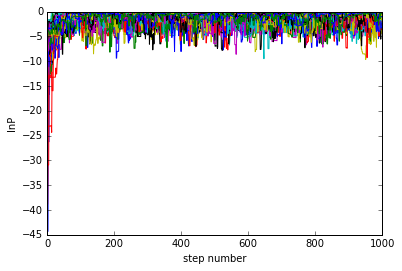

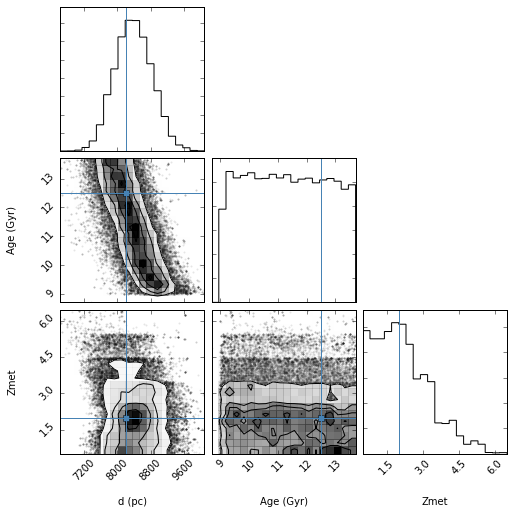

In [868]:
[plt.plot(sampler_4.lnprobability[i,:]) for i in range(100)]
plt.xlabel('step number')
plt.ylabel('lnP')
plt.show()

fig = corner.corner(sampler_4.flatchain[4000:], labels=['d (pc)','Age (Gyr)','Zmet'],truths=[8200,12.5,2])
plt.show()

This is a clear improvement over 2.2 - with just the two filters we couldn't do nearly as good a job constraining the metallicity or the distance.  We still have no idea what the age should be, though.

## 2.5

In [872]:
# Assume d = 8.2 kpc, age = 12.5 Gyr, log[Fe/H] = -2.1
#using MILES spectral library and MIST evolution models

d = 8200
age = 12.5 #Gyr
feh = -2.1
zmet = 2 # this is a metallicity of 1% solar in the MIST models
cluster_mass = 2.0e5 #msun # Assume the cluster mass is perfectly known
sigma = 0.1 #mag

sp = fsps.StellarPopulation(compute_vega_mags=False, sfh=0, tage = age, zmet = zmet)

In [873]:
mags = sp.get_mags(tage = age, bands=['galex_fuv','u','b','WFC_ACS_F606W', 'WFC_ACS_F814W'])
f,u,b,v,i = mags.T[0],mags.T[1],mags.T[2],mags.T[3],mags.T[4]
model_mass = sp.stellar_mass
mass_ratio = cluster_mass/model_mass

In [874]:
f_cluster = lum_mag(mass_ratio*mag_lum(f))
u_cluster = lum_mag(mass_ratio*mag_lum(u))
b_cluster = lum_mag(mass_ratio*mag_lum(b))
v_cluster = lum_mag(mass_ratio*mag_lum(v))
i_cluster = lum_mag(mass_ratio*mag_lum(i))

f_app = distance_modulus(d,f_cluster)
u_app = distance_modulus(d,u_cluster)
b_app = distance_modulus(d,b_cluster)
v_app = distance_modulus(d,v_cluster)
i_app = distance_modulus(d,i_cluster)

In [881]:
f_with_err = np.random.normal(f_app,sigma,1)
u_with_err = np.random.normal(u_app,sigma,1)
b_with_err = np.random.normal(b_app,sigma,1)
v_with_err = np.random.normal(v_app,sigma,1)
i_with_err = np.random.normal(i_app,sigma,1)

stars = [f_with_err,u_with_err,b_with_err,v_with_err,i_with_err,sigma]

In [882]:
#theta = [distance (pc), age (Gyr), zmet]
#stars = [f,u,b,v,i,sigma]

def lnlike(theta,stars):
    #initialize variables
    dist = theta[0]
    age = theta[1]
    zmet = int(np.around(theta[2]))
    
    f_data = stars[0]
    u_data = stars[1]
    b_data = stars[2]
    v_data = stars[3]
    i_data = stars[4]
    sigma = stars[5]
    
    #adjust stellar model
    sp.params['zmet'] = zmet
    mags = sp.get_mags(tage = age, bands=['galex_fuv','u','b','WFC_ACS_F606W', 'WFC_ACS_F814W'])
    model_mass = sp.stellar_mass
    f = mags.T[0]
    u = mags.T[1]
    b = mags.T[2]
    v = mags.T[3]
    i = mags.T[4]
    
    #put the model at the correct mass and distance
    mass_ratio = cluster_mass/model_mass
    
    f_cluster = lum_mag(mass_ratio*mag_lum(f))
    u_cluster = lum_mag(mass_ratio*mag_lum(u))
    b_cluster = lum_mag(mass_ratio*mag_lum(b))    
    v_cluster = lum_mag(mass_ratio*mag_lum(v))
    i_cluster = lum_mag(mass_ratio*mag_lum(i))
    
    f_app = distance_modulus(dist,f_cluster)
    u_app = distance_modulus(dist,u_cluster)
    b_app = distance_modulus(dist,b_cluster)    
    v_app = distance_modulus(dist,v_cluster)
    i_app = distance_modulus(dist,i_cluster)
    
    #compute difference between v and i, put into Gaussian
    lnlk = -0.5 * np.sum(((f_app - f_data)**2 + (u_app - u_data)**2 + (b_app - b_data)**2 + (v_app - v_data)**2 + (i_app - i_data)**2)/(2. * sigma**2))
    return lnlk

In [883]:
def lnprior(theta,stars):
    '''Flat prior for now.'''
    if 5000 < theta[0] < 15000 and 9.0 <= theta[1] <= 13.7 and 0.5 < theta[2] < 6.5:
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta,stars):
    if np.isfinite(lnprior(theta,stars)):
        return lnprior(theta,stars) + lnlike(theta,stars)
    else:
        return -np.inf

In [884]:
ndim, nwalkers = 3, 100  
thetaguess = np.asarray([8200,11.0,5])
def p0gen(thetaguess):
    '''Takes in a guess at params, makes tiny ball of walkers around it
    ensuring distance between walkers in each dimension is proportional
    to the characteristic size scale'''
    return np.add(np.multiply(1e-1*np.random.randn(len(thetaguess)),thetaguess),thetaguess)

#randomize initial position of walkers
p0 = [p0gen(thetaguess) for i in range(nwalkers)]

sampler_5 = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[stars])
sampler_5.run_mcmc(p0, 1000)

(array([[  8.68844538e+03,   1.25686434e+01,   1.52471791e+00],
        [  9.00599129e+03,   9.62365310e+00,   3.29646134e+00],
        [  9.17365055e+03,   1.03505634e+01,   1.57062030e+00],
        [  7.65112541e+03,   1.31410913e+01,   3.19979342e+00],
        [  8.46375069e+03,   1.15070779e+01,   4.34602010e+00],
        [  8.79509184e+03,   1.03977105e+01,   3.20515015e+00],
        [  8.89422524e+03,   1.03536195e+01,   2.57824105e+00],
        [  8.67217206e+03,   1.00854818e+01,   2.80553921e+00],
        [  9.01988687e+03,   1.15293400e+01,   2.41614018e+00],
        [  9.16019530e+03,   9.48465506e+00,   2.49037534e+00],
        [  8.29490705e+03,   1.20751823e+01,   3.28176049e+00],
        [  9.02331224e+03,   9.33111244e+00,   3.08623298e+00],
        [  8.82781156e+03,   1.10791432e+01,   2.27668201e+00],
        [  8.45387479e+03,   1.14098352e+01,   3.45486459e+00],
        [  7.56299269e+03,   1.35287110e+01,   3.01253340e+00],
        [  8.67719072e+03,   1.02031391e

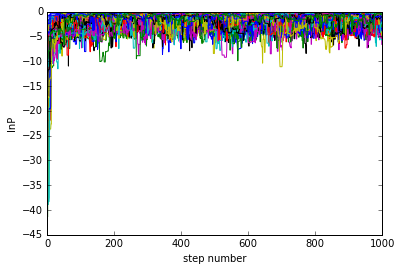

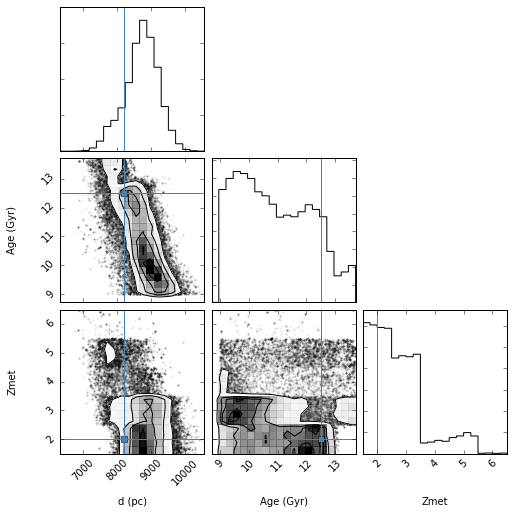

In [885]:
[plt.plot(sampler_5.lnprobability[i,:]) for i in range(100)]
plt.xlabel('step number')
plt.ylabel('lnP')
plt.show()

fig = corner.corner(sampler_5.flatchain[4000:], labels=['d (pc)','Age (Gyr)','Zmet'],truths=[8200,12.5,2])
plt.show()

Pretty unexpected result - we get a bimodal distribution in age, preferring both the 'correct' value of ~12.5 Gyr and a low value near 9.8 Gyr. The preferred distance is now too far by ~500 pc. The metallicity seems to remain more-or-less correct.  At least the constraints are stronger.

UV observations of globulars may be difficult because (1) low-mass stars are red and very weak in ultraviolet - for a model cluster at 12.5 Gyr there's a 7 magnitude difference between V and FUV (see below), so it may be hard to get very accurate photometry and (2) there's no large FUV space telescope currently in operation.

In [887]:
print(sp.get_mags(tage = 12.5, bands=['v']))
print(sp.get_mags(tage = 12.5, bands=['galex_fuv']))

[ 6.17860309]
[ 13.75390797]
